In [59]:
import sys
sys.path.append("../")
from src.data.common import DownloadedRepositories, load_repositories_json

from pathlib import Path

import json
import tqdm
from src.utils.compare import *

from joblib import Parallel, delayed
import seaborn as sns

import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

In [60]:
repos = load_repositories_json(Path('../data/repositories_download_status.json'))

Loading info about cloned repos from '../data/repositories_download_status.json'...


In [61]:
with open("../data/external/DevGPT/snapshot_20230914/20230914_083202_commit_sharings.json") as f:
    data = json.load(f)

In [62]:
# all_repos = DownloadedRepositories(Path('../data/repositories_download_status.json'))


# # get url
# diffs = {}
# bad_url = []
# for source in tqdm.tqdm(data['Sources']):

#     try:
#         R = source['RepoName']
#         S  = source['Sha']
#         the_repo = all_repos.repo(R)
#         curr_diff = the_repo.unidiff(S) 
#         diffs[(R,S)] = curr_diff
#     except:
#         bad_url.append((R,S))

In [63]:
def run_joblib(source, conv, compare):
    
    if 'Conversations' not in conv:
        return {}
    
    all_repos = DownloadedRepositories(Path('../data/repositories_download_status.json'))

    R = source['RepoName']
    S  = source['Sha']
    U = source['URL']
    curr_diff = None
    try:
        the_repo = all_repos.repo(R)
        curr_diff = the_repo.unidiff(S) 
    except:
        pass
    
    if curr_diff:
        return U, diff_to_conversation(curr_diff, conv, compare=compare)
    
    return U, {}

In [64]:
#ret = Parallel(n_jobs=-1)(delayed(run_joblib)(source, conv, compare=CompareLines) for source in tqdm.tqdm(data['Sources']) for conv in source['ChatgptSharing'])


In [65]:
# for source in tqdm.tqdm(data['Sources']):
#     for conv in source['ChatgptSharing']:
#         print(run_joblib(conv))
#         break

In [66]:
def plot_ret(ret):
    df = []
    for rl in ret:
        if not isinstance(rl, tuple):
            continue
        
        r = rl[1]
        if 'ALL' in r:
            df.append({'cov' : r['ALL']['coverage'], 'all': r['ALL']['all']})
    df = pd.DataFrame(df)
    df['%'] = df['cov']/df['all']
    sns.histplot(df, x='%')
    plt.show()
    

In [67]:
ret_fragments = Parallel(n_jobs=1000)(delayed(run_joblib)(source, conv, compare=CompareFragments) for source in tqdm.tqdm(data['Sources']) for conv in source['ChatgptSharing'])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 571/571 [00:00<00:00, 114882.12it/s]
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repo

Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.j

Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.j

Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.j

Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.j

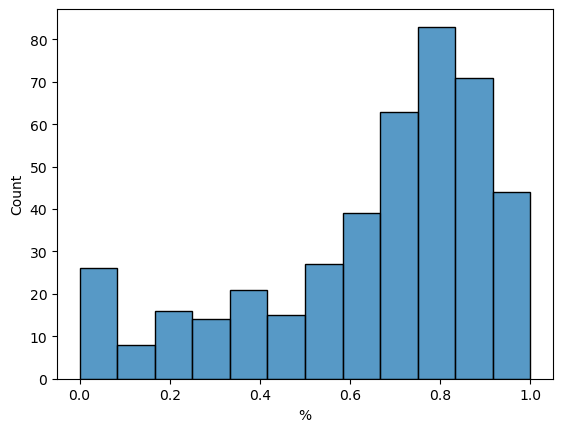

In [68]:
plot_ret(ret_fragments)

In [56]:
ret_fragments

[('https://github.com/grnpin/textbox/commit/0dfc4385b723060e1e6a21da17a952bd908084ff',
  {'ALL': {'coverage': 1,
    'all': 238,
    'lines': [133],
    'preimage': [134,
     20,
     151,
     24,
     152,
     154,
     29,
     30,
     163,
     164,
     169,
     171,
     47,
     48,
     49,
     50,
     175,
     176,
     182,
     183,
     56,
     57,
     58,
     184,
     185,
     187,
     188,
     191,
     64,
     65,
     193,
     195,
     197,
     70,
     203,
     204,
     205,
     108,
     109,
     121,
     250,
     251,
     124,
     126,
     127],
    'preimage_all': 136,
    'preimage_coverage': 45}}),
 ('https://github.com/grnpin/textbox/commit/811d09acdca361c81281c7d71587ebdbd8437453',
  {'ALL': {'coverage': 33,
    'all': 70,
    'lines': [64,
     65,
     129,
     133,
     136,
     9,
     78,
     79,
     16,
     17,
     80,
     81,
     82,
     145,
     119,
     88,
     120,
     96,
     97,
     98,
     104,
     41,
   

In [57]:
def plot_ret_pre(ret):
    df = []
    for rl in ret:
        if not isinstance(rl, tuple):
            continue
        
        r = rl[1]
        if 'ALL' in r:
            df.append({'cov' : r['ALL']['preimage_coverage'], 'all': r['ALL']['preimage_all']})
    df = pd.DataFrame(df)
    df['%'] = df['cov']/df['all']
    sns.histplot(df, x='%')
    plt.show()

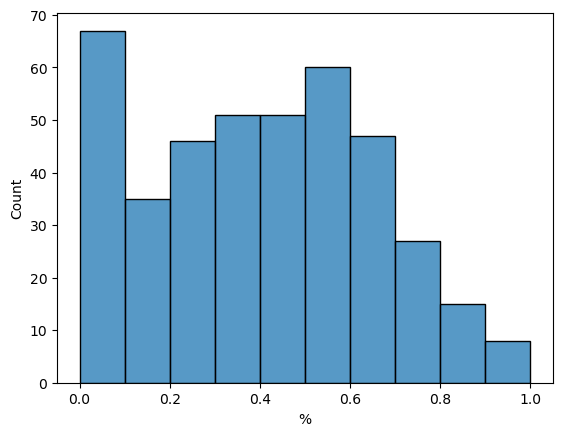

In [69]:
plot_ret_pre(ret_fragments)